In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from tqdm.notebook import tqdm
import utils



In [3]:
from torchvision import datasets
from torchvision import transforms as T

In [4]:
train_augs=T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ToTensor(), #(h,w,c) to (c,h,w) ie shifts channel to 0th axis while converting img to pytprch tensor
    T.Normalize(mean=0.5, std=0.5)
])


valid_augs=T.Compose([
    T.ToTensor(),
    T.Normalize(mean=0.5, std=0.5)
])

In [5]:
trainset=datasets.MNIST('./', download=True, train=True, transform=train_augs)

testset=datasets.MNIST('./', download=True, train=False, transform=valid_augs)

In [6]:
trainset, validset=torch.utils.data.random_split(trainset, [50000, 10000])

torch.Size([1, 28, 28])
torch.Size([28, 28, 1])


Text(0.5, 1.0, '3')

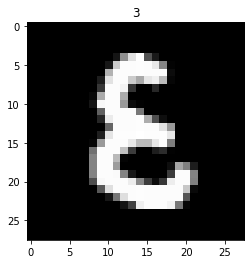

In [7]:
idx=1
image,label=trainset[idx]
print(image.shape)
print(image.permute(1,2,0).shape) #cwh to hwc bec pytorch has cwh tensors when totensor method is called
plt.imshow(image.permute(1,2,0), cmap='gray')
plt.title(label)

In [8]:
from torch.utils.data import DataLoader


In [9]:
bs=64

trainloader=DataLoader(trainset, batch_size=bs, shuffle=True)
validloader=DataLoader(validset, batch_size=bs)
testloader=DataLoader(testset, batch_size=bs)

In [10]:
len(trainloader), len(validloader), len(testloader)

(782, 157, 157)

In [11]:
for images, labels in trainloader:
    print(images.shape)
    print(labels.shape)
    break;
    

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [12]:
import models

In [13]:
from models import DigitModel

model=DigitModel()
device='cpu'
model.to(device)

DigitModel(
  (cnn_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_featu

In [14]:
def train_fn(model, dataloader, criterion, optimizer):
    model.train()
    total_loss=0.0
    total_acc=0.0
    
    for images, labels in tqdm(dataloader):
        images=images.to(device)
        labels=labels.to(device)
        
        optimizer.zero_grad()
        logits=model(images)
        loss=criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss+=loss.item()
        total_acc+=utils.multiclass_accuracy(logits, labels)
        
    return total_loss/len(dataloader), total_acc/len(dataloader)

In [15]:
def eval_fn(model, dataloader, criterion):
    model.eval()
    total_loss=0.0
    total_acc=0.0
    
    with torch.no_grad():
    
        for images, labels in tqdm(dataloader):
            images=images.to(device)
            labels=labels.to(device)
            
        
            logits=model(images)
            loss=criterion(logits, labels)
            
            
            total_loss+=loss.item()
            total_acc+=utils.multiclass_accuracy(logits, labels)
        
    return total_loss/len(dataloader), total_acc/len(dataloader)

In [16]:
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.003)

In [17]:
best_valid_loss=np.inf

for i in range(7):
    train_loss, train_acc=train_fn(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc=eval_fn(model, trainloader, criterion)
    
    print(f"Epoch{i+1} Train Loss: {train_loss} Train Acc: {train_acc}")
    print(f"Epoch{i+1} Validation loss: {valid_loss} Validation Acc: {valid_acc}")
    
    if (valid_loss< best_valid_loss):
        torch.save(model.state_dict(), 'best_weights.pt')
        print('SAVED BEST MODEL')
        best_valid_loss=valid_loss

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch1 Train Loss: 0.7500715456579042 Train Acc: 0.7450847029685974
Epoch1 Validation loss: 0.3620852957601133 Validation Acc: 0.8958399891853333
SAVED BEST MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch2 Train Loss: 0.36882472398412197 Train Acc: 0.887627899646759
Epoch2 Validation loss: 0.17332964294287553 Validation Acc: 0.948309600353241
SAVED BEST MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch3 Train Loss: 0.29311979645886993 Train Acc: 0.912304162979126
Epoch3 Validation loss: 0.1405918852466604 Validation Acc: 0.9575607180595398
SAVED BEST MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch4 Train Loss: 0.251161658393262 Train Acc: 0.9245524406433105
Epoch4 Validation loss: 0.13117718563446074 Validation Acc: 0.9595588445663452
SAVED BEST MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch5 Train Loss: 0.23016603329621466 Train Acc: 0.9294877052307129
Epoch5 Validation loss: 0.12039806539921658 Validation Acc: 0.9626159071922302
SAVED BEST MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch6 Train Loss: 0.21740423532350517 Train Acc: 0.9341831803321838
Epoch6 Validation loss: 0.10491982078991945 Validation Acc: 0.9687699675559998
SAVED BEST MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch7 Train Loss: 0.2077440871592716 Train Acc: 0.9372802376747131
Epoch7 Validation loss: 0.10898820806742476 Validation Acc: 0.9679707288742065


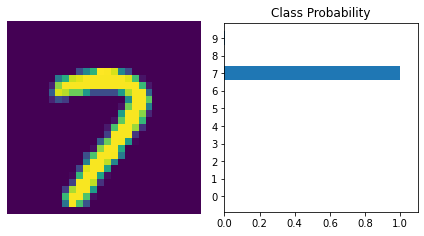

In [22]:
image, label = testset[223]

weights=torch.load('best_weights.pt')
model.load_state_dict(weights)

model.eval()
with torch.no_grad():
    logits=model(image.unsqueeze(0))
    ps=torch.nn.Softmax(dim=1)(logits)[0]
    utils.view_classify(image, ps)